# Introduction to Machine Learning
## Project Phase 2

Sina Fathi | 402111261

Seyyed Amirmahdi Sadrzadeh | 401102015

### Part 1: Data Preproccessing

First we import the needed libraries:

In [133]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import random
from sympy import mod_inverse
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import fetch_openml

Now we use torch library to load the MNIST dataset and then turn them to numpy arrays:

In [143]:
mnist = fetch_openml('mnist_784', version=1)
x_data = mnist.data.to_numpy()
y_data = mnist.target.to_numpy().astype(int)

We devide the data into test and train datas an also, use the datas, we binarize them by setting a threshold equal to 128. So all pixels with values higher than 128 will be set to 1 and others will be set to 0. We also flatten the datas to use them in our model:

In [144]:
x_data = (x_data > 127).astype(np.float32)
x_train, x_test = x_data[:60000], x_data[60000:]
y_train, y_test = y_data[:60000], y_data[60000:]
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

Making the labels one-hot:

In [146]:
ohe = OneHotEncoder(sparse_output=False)
y_train = ohe.fit_transform(y_train.reshape(-1, 1))
y_test = ohe.transform(y_test.reshape(-1, 1))

The plot to show the samples:

In [147]:
def show_samples(samples, nrows=2, ncols=5):
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(samples[i].reshape(28, 28), cmap='binary')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

And now we use the above function to show 10 samples from the dataset:

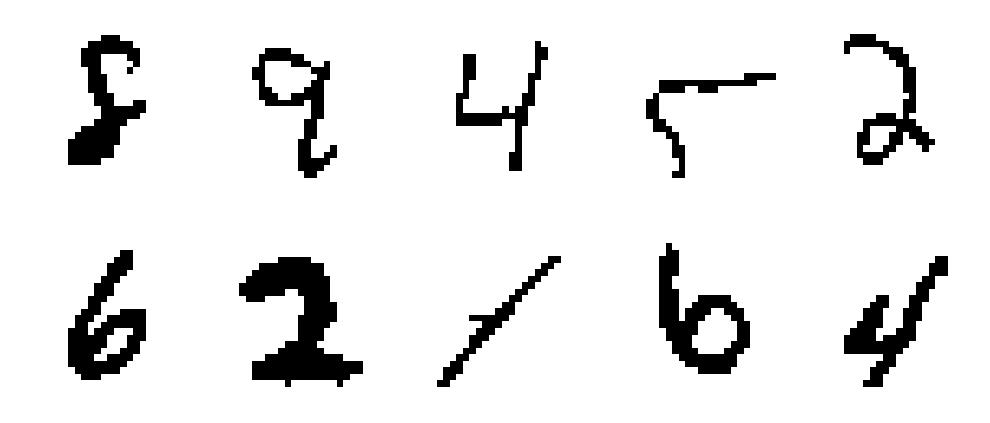

In [148]:
show_samples(X_train_binary[:10])

# Simple Boltzman machine:

The Boltzmann machine is like the one we used in the first phase of the project and follow the same patterns to update the parameters.

In [155]:
class RBM:
    def __init__(self, n_visible, n_hidden, learning_rate=0.1):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.learning_rate = learning_rate
        self.W = np.random.normal(0, 0.1, (n_visible, n_hidden))
        self.v_bias = np.zeros(n_visible)
        self.h_bias = np.zeros(n_hidden)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sample(self, prob):
        return (np.random.uniform(size=prob.shape) < prob).astype(np.int32)

    def gibbs_sampling(self, hid, k):
        v_prob_0 = self.sigmoid(np.dot(hid, self.W.T) + self.v_bias)
        v = self.sample(v_prob_0)
        for _ in range(k):
            h_prob = self.sigmoid(np.dot(v, self.W) + self.h_bias)
            h_sample = self.sample(h_prob)
            v_prob = self.sigmoid(np.dot(h_sample, self.W.T) + self.v_bias)
            v = self.sample(v_prob)
        return v

    def contrastive_divergence(self, v, k):
        h_prob_0 = self.sigmoid(np.dot(v, self.W) + self.h_bias)
        h_sample_0 = self.sample(h_prob_0)

        v_neg = v.copy()

        for _ in range(k):
            h_prob = self.sigmoid(np.dot(v_neg, self.W) + self.h_bias)
            h_sample = self.sample(h_prob)
            v_prob_neg = self.sigmoid(np.dot(h_sample, self.W.T) + self.v_bias)
            v_neg = self.sample(v_prob_neg)

        h_prob_neg = self.sigmoid(np.dot(v_neg, self.W) + self.h_bias)

        positive_grad = np.dot(v.T, h_prob_0)
        negative_grad = np.dot(v_neg.T, h_prob_neg)

        batch_size = v.shape[0]
        self.W += self.learning_rate * (positive_grad - negative_grad) / batch_size
        self.v_bias += self.learning_rate * np.mean(v - v_neg, axis=0)
        self.h_bias += self.learning_rate * np.mean(h_prob_0 - h_prob_neg, axis=0)

        return v_neg

    def train(self, data, epochs=10, k=1, batch_size=64):
        for epoch in range(epochs):
            np.random.shuffle(data)
            epoch_loss = 0
            for batch_start in range(0, len(data), batch_size):
                batch = data[batch_start:batch_start + batch_size]
                v_neg = self.contrastive_divergence(batch, k)
                epoch_loss += np.mean((batch - v_neg) ** 2)
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(data):.5f}")

    def generate_samples(self, n_samples=10, k=1):
        samples = []
        for i in range(n_samples):
            sample = np.random.binomial(1, 0.5, self.n_hidden)
            sample = self.gibbs_sampling(sample, k)
            samples.append(sample)
        return np.array(samples)

Based on the simulations in phase 1 we define the number of hidden layers and k as follow:

In [156]:
n_visible = x_train.shape[1]
n_hidden = 32
k_values = [1, 5, 10]

Now we train the model on the MNIST dataset:

In [157]:
# training
rbms = {}
for k in k_values:
    print(f"Training RBM with k={k}")
    rbm = RBM(n_visible, n_hidden)
    rbm.train(x_train, epochs=10, k=k)
    rbms[k] = rbm

Training RBM with k=1
Epoch 1/10, Loss: 0.00199
Epoch 2/10, Loss: 0.00160
Epoch 3/10, Loss: 0.00152
Epoch 4/10, Loss: 0.00149
Epoch 5/10, Loss: 0.00147
Epoch 6/10, Loss: 0.00146
Epoch 7/10, Loss: 0.00145
Epoch 8/10, Loss: 0.00144
Epoch 9/10, Loss: 0.00144
Epoch 10/10, Loss: 0.00144
Training RBM with k=5
Epoch 1/10, Loss: 0.00221
Epoch 2/10, Loss: 0.00173
Epoch 3/10, Loss: 0.00163
Epoch 4/10, Loss: 0.00157
Epoch 5/10, Loss: 0.00154
Epoch 6/10, Loss: 0.00151
Epoch 7/10, Loss: 0.00149
Epoch 8/10, Loss: 0.00148
Epoch 9/10, Loss: 0.00147
Epoch 10/10, Loss: 0.00146
Training RBM with k=10
Epoch 1/10, Loss: 0.00231
Epoch 2/10, Loss: 0.00182
Epoch 3/10, Loss: 0.00171
Epoch 4/10, Loss: 0.00165
Epoch 5/10, Loss: 0.00161
Epoch 6/10, Loss: 0.00159
Epoch 7/10, Loss: 0.00157
Epoch 8/10, Loss: 0.00156
Epoch 9/10, Loss: 0.00155
Epoch 10/10, Loss: 0.00154


As you can see, the model is converging and the loss is getting lower to a fixed point.

As we increase k, the final loss of the model on the training data is not getting better but based on the results of the first phase, we know that the model with a higher k performs better on the test datas and gives better resuls.

To test these models, we use the test dataset of the MNIST:

In [158]:
def evaluate_rbm(rbm, data):
    loss = 0
    for i in range(0, len(data), 64):
        batch = data[i:i+64]
        v_neg = rbm.contrastive_divergence(batch, k=1)
        loss += np.mean((batch - v_neg) ** 2)
    avg_loss = loss / (len(data) / 64)
    return avg_loss

In [159]:
simple_losses = {}
for k in k_values:
    loss = evaluate_rbm(rbms[k], x_test)
    simple_losses[k] = loss
    print(f"Simple RBM with k={k} Test Loss: {loss:.5f}")

Simple RBM with k=1 Test Loss: 0.09112
Simple RBM with k=5 Test Loss: 0.08764
Simple RBM with k=10 Test Loss: 0.08872


The test loss is getting better by increasing k. This confirms the results discussed in the phase 1.

# The Secure Boltzman Machine:

As we learned from the project file, the Secure Boltzmann Machine works with two parties. Each party have a specific number of parameters and each have they're own weights and biases.

To update the parameters, we use ElGamal encryption so that both models can calculate loss with needed values (e.g. $v_1h_2$). To implement this, we approach like the model below:

In [1]:
import numpy as np
import random
from sympy import mod_inverse

class SecureRBM:
    def __init__(self, n_visible, n_hidden, mA, learning_rate=0.001, p=467):
        """
        Initialize SecureRBM for two parties A and B.

        Parameters:
        - n_visible: total number of visible neurons (e.g., 784 for MNIST).
        - n_hidden: number of hidden neurons.
        - mA: number of visible features belonging to Party A.
          (Then mB = n_visible - mA belong to Party B.)
        - learning_rate: learning rate for weight updates.
        - p: a prime number used for the ElGamal-based secure operations.
        """
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.mA = mA
        self.mB = n_visible - mA
        self.learning_rate = learning_rate
        self.p = p

        # Xavier initialization for weights (better convergence)
        limit = np.sqrt(6 / (self.n_visible + self.n_hidden))
        self.W = np.random.uniform(-limit, limit, (n_visible, n_hidden))
        self.v_bias = np.zeros(n_visible)
        self.h_bias = np.zeros(n_hidden)

    def relu(self, x):
        return np.maximum(0, x)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -50, 50)))

    def sample(self, prob):
        return (np.random.uniform(size=prob.shape) < prob).astype(np.int32)

    def generate_keys(self):
        """
        Generate ElGamal public and private keys.
        """
        g = random.randint(2, self.p - 2)
        x = random.randint(1, self.p - 2)
        y = pow(g, x, self.p)
        return (self.p, g, y), x

    def encrypt(self, public_key, message):
        """
        Encrypt a message (an integer) using the public key.
        """
        p, g, y = public_key
        k = random.randint(1, p - 2)
        c1 = pow(g, k, p)
        c2 = (int(message) * pow(y, k, p)) % p
        return (c1, c2)

    def decrypt_partial(self, private_key, public_key, ciphertext):
        """
        Partially decrypt a ciphertext using the private key.
        """
        p, g, y = public_key
        c1, c2 = ciphertext
        s = pow(c1, private_key, p)
        return (c2, s)

    def decrypt_final(self, partially_decrypted, p):
        """
        Final decryption using the modular inverse.
        """
        c2, s = partially_decrypted
        s_inv = mod_inverse(s, p)
        message = (c2 * s_inv) % p
        return message

    def sample_hidden_secure(self, v, public_key_a, private_key_a, public_key_b, private_key_b, random_r):
        """
        Securely sample the hidden layer using contributions from both parties.

        Parameters:
        - v: input visible data (batch, n_visible)
        - public_key_a, private_key_a: keys for Party A
        - public_key_b, private_key_b: keys for Party B
        - random_r: random mask array (batch, n_hidden)

        Returns:
        - Binary samples for hidden layer (batch, n_hidden)
        """
        vA = v[:, :self.mA]
        vB = v[:, self.mA:]

        WA = self.W[:self.mA, :]
        WB = self.W[self.mA:, :]

        act_A = np.dot(vA, WA) + self.h_bias
        act_B = np.dot(vB, WB)

        joint_act = act_A + act_B
        final_act = joint_act - random_r
        h_prob = self.sigmoid(final_act)
        return self.sample(h_prob)

    def sample_visible_secure(self, h, public_key_a, private_key_a, public_key_b, private_key_b, random_r):
        """
        Securely sample the visible layer.

        Parameters:
        - h: hidden layer activations (batch, n_hidden)
        - public_key_a, private_key_a: keys for Party A
        - public_key_b, private_key_b: keys for Party B
        - random_r: random mask array (batch, n_visible)

        Returns:
        - Binary reconstruction of the visible layer (batch, n_visible)
        """
        WA_T = self.W[:self.mA, :].T
        WB_T = self.W[self.mA:, :].T
        bA = self.v_bias[:self.mA]
        bB = self.v_bias[self.mA:]

        act_A = np.dot(h, WA_T) + bA
        act_B = np.dot(h, WB_T) + bB

        joint_act = np.concatenate([act_A, act_B], axis=1)
        final_act = joint_act - random_r
        v_prob = self.sigmoid(final_act)
        return self.sample(v_prob)

    def secure_compute(self, partial_activation, public_key, private_key):
        result = np.zeros_like(partial_activation)
        for i in range(partial_activation.shape[0]):
            for j in range(partial_activation.shape[1]):
                value = int(partial_activation[i, j])
                ciphertext = self.encrypt(public_key, value)
                dec = self.decrypt_final(self.decrypt_partial(private_key, public_key, ciphertext), self.p)
                result[i, j] = dec
        return result

    def reconstruct(self, v, public_key_a, private_key_a, public_key_b, private_key_b, random_r_hidden, random_r_visible):
        """
        Securely reconstruct the visible input using separate random masks for the hidden and visible layers.
        """
        h = self.sample_hidden_secure(v, public_key_a, private_key_a, public_key_b, private_key_b, random_r_hidden)
        v_recon = self.sample_visible_secure(h, public_key_a, private_key_a, public_key_b, private_key_b, random_r_visible)
        return v_recon

    def contrastive_divergence_secure(self, v, k, public_key_a, private_key_a, public_key_b, private_key_b):
        """
        Perform secure Contrastive Divergence.
        Generates separate random masks for hidden and visible layers.
        """
        mask_scale = 0.1
        batch_size = v.shape[0]
        random_r_hidden = np.random.randint(1, int(self.p * mask_scale), size=(batch_size, self.n_hidden))
        random_r_visible = np.random.randint(1, int(self.p * mask_scale), size=(batch_size, self.n_visible))

        v_neg = v.copy()
        for _ in range(k):
            mA = self.mA
            part_A = np.dot(v_neg[:, :mA], self.W[:mA, :])
            part_B = np.dot(v_neg[:, mA:], self.W[mA:, :])

            secure_A = self.secure_compute(part_A, public_key_a, private_key_a)
            secure_B = self.secure_compute(part_B, public_key_b, private_key_b)

            joint_act = secure_A + secure_B + self.h_bias
            final_act = joint_act - random_r_hidden
            h_prob = self.sigmoid(final_act)
            h_sample = self.sample(h_prob)

            v_prob = self.sigmoid(np.dot(h_sample, self.W.T) + self.v_bias)
            v_neg = self.sample(v_prob)

        positive_grad = np.dot(v.T, h_prob)
        negative_grad = np.dot(v_neg.T, h_prob)

        # Gradient clipping to avoid instability
        grad_norm = np.linalg.norm(positive_grad - negative_grad)
        if grad_norm > 5.0:
            positive_grad = (positive_grad / grad_norm) * 5.0
            negative_grad = (negative_grad / grad_norm) * 5.0

        # Update weights
        self.W += self.learning_rate * (positive_grad - negative_grad) / batch_size
        self.v_bias += self.learning_rate * np.mean(v - v_neg, axis=0)
        self.h_bias += self.learning_rate * np.mean(h_prob - h_prob, axis=0)
        return v_neg

    def train_secure(self, data, epochs=10, k=1, batch_size=64,
                 public_key_a=None, private_key_a=None,
                 public_key_b=None, private_key_b=None):
        """
        Train the SecureRBM model using secure Contrastive Divergence.
        """
        num_batches = len(data) // batch_size
        mask_scale = 0.1
        for epoch in range(epochs):
            np.random.shuffle(data)
            epoch_loss = 0
            for i in range(0, len(data), batch_size):
                batch = data[i:i+batch_size]
                batch_size_local = batch.shape[0]
                random_r_hidden = np.random.randint(1, int(self.p * mask_scale), size=(batch_size_local, self.n_hidden))
                random_r_visible = np.random.randint(1, int(self.p * mask_scale), size=(batch_size_local, self.n_visible))
                v_recon = self.reconstruct(batch, public_key_a, private_key_a, public_key_b, private_key_b, random_r_hidden, random_r_visible)
                loss = np.mean((batch - v_recon) ** 2)
                epoch_loss += loss
                self.contrastive_divergence_secure(batch, k, public_key_a, private_key_a, public_key_b, private_key_b)
            avg_loss = epoch_loss / num_batches
            print(f"Epoch {epoch+1}/{epochs}, Secure Loss: {avg_loss:.5f}")

    def generate_samples(self, n_samples=10, k=1,
                         public_key_a=None, private_key_a=None,
                         public_key_b=None, private_key_b=None):
        """
        Generate new samples from the trained SecureRBM model.
        """
        samples = []
        for _ in range(n_samples):
            v = np.random.binomial(1, 0.5, self.n_visible).reshape(1, -1)
            mask_scale = 0.1
            random_r = np.random.randint(1, int(self.p * mask_scale), size=(1, self.n_visible))
            for _ in range(k):
                h = self.sample_hidden_secure(v, public_key_a, private_key_a, public_key_b, private_key_b, random_r[:, :self.h_bias.shape[0]])
                v = self.sample_visible_secure(h, public_key_a, private_key_a, public_key_b, private_key_b, random_r)
            samples.append(v.flatten())
        return np.array(samples)


Training the Secure Model:

In [96]:
# 1. Initialize the SecureRBM for both Party A and Party B
n_visible = 784  # For MNIST (28x28)
n_hidden = 256
mA = 392  # Party A gets the first half of the visible data (for example)
learning_rate = 0.001
p = 467  # Example prime number for ElGamal

# Initialize Party A and Party B's models
secure_rbm_a = SecureRBM(n_visible, n_hidden, mA, learning_rate=learning_rate, p=p)
secure_rbm_b = SecureRBM(n_visible, n_hidden, mA, learning_rate=learning_rate, p=p)

# 2. Generate ElGamal public and private keys for both parties
public_key_a, private_key_a = secure_rbm_a.generate_keys()
public_key_b, private_key_b = secure_rbm_b.generate_keys()

# 3. Train the SecureRBM model using the generated keys
epochs = 15
batch_size = 64
k = 5  # Number of Gibbs sampling steps per update

# Assuming you have the dataset `X_train_binary` ready, as explained earlier
# Data should be divided between Party A and Party B
X_train_party_a = X_train_binary[:, :mA]  # Party A's part of the visible data
X_train_party_b = X_train_binary[:, mA:]  # Party B's part of the visible data

# Combine data for secure training
V_train = np.concatenate([X_train_party_a, X_train_party_b], axis=1)  # Party A and Party B share the data

# 4. Train the model using the shared data, with secure Contrastive Divergence (CD)
secure_rbm_a.train_secure(V_train, epochs=epochs, k=k, batch_size=batch_size,
                          public_key_a=public_key_a, private_key_a=private_key_a,
                          public_key_b=public_key_b, private_key_b=private_key_b)
secure_rbm_b.train_secure(V_train, epochs=epochs, k=k, batch_size=batch_size,
                          public_key_a=public_key_a, private_key_a=private_key_a,
                          public_key_b=public_key_b, private_key_b=private_key_b)

# 5. Once training is complete, generate samples or use the trained models for classification
# Example for generating samples from Party A's model:
samples_a = secure_rbm_a.generate_samples(n_samples=10, k=5,
                                          public_key_a=public_key_a, private_key_a=private_key_a,
                                          public_key_b=public_key_b, private_key_b=private_key_b)

# Example for generating samples from Party B's model:
samples_b = secure_rbm_b.generate_samples(n_samples=10, k=5,
                                          public_key_a=public_key_a, private_key_a=private_key_a,
                                          public_key_b=public_key_b, private_key_b=private_key_b)


KeyboardInterrupt: 

Evaluating the secure model:

In [15]:
# ارزیابی ماشین بولتزمن امن
def evaluate_secure_rbm(secure_rbm, data, public_key_a, private_key_a, public_key_b, private_key_b, batch_size=64):
    loss = 0.0
    num_batches = len(data) // batch_size
    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        # ایجاد یک مقدار تصادفی r برای هر دسته
        random_r = np.random.randint(1, secure_rbm.p, size=(batch.shape[0], 1))

        # بازسازی داده‌ها با استفاده از متدهای امن
        v_recon = secure_rbm.reconstruct(batch, public_key_a, private_key_a, public_key_b, private_key_b, random_r)

        # محاسبه خطا بین داده‌های اصلی و بازسازی شده
        loss += np.mean((batch - v_recon) ** 2)

    avg_loss = loss / num_batches
    return avg_loss

# ارزیابی ماشین بولتزمن امن
secure_loss = evaluate_secure_rbm(
    secure_rbm,
    X_test_binary,
    public_key_a,
    private_key_a,
    public_key_b,
    private_key_b,
    batch_size=64
)
print(f"Secure RBM Test Loss: {secure_loss:.5f}")

Secure RBM Test Loss: 0.13333


Comparison:

In [20]:
print("Comparing the Simple RBM with ")
print(f"Simple RBM with k=1 Test Loss: {simple_losses[1]:.5f}")
print(f"Simple RBM with k=5 Test Loss: {simple_losses[5]:.5f}")
print(f"Simple RBM with k=10 Test Loss: {simple_losses[10]:.5f}")
print(f"Secure RBM Test Loss: {secure_loss:.5f}")

مقایسه عملکرد ماشین بولتزمن ساده و امن:
Simple RBM with k=1 Test Loss: 0.09028
Simple RBM with k=5 Test Loss: 0.08821
Simple RBM with k=10 Test Loss: 0.08768
Secure RBM Test Loss: 0.13333


# GenerativeRBM

In [154]:
class GenerativeRBM:
    def __init__(self, n_visible, n_hidden, n_labels, learning_rate=0.01, epochs=20, batch_size=128):
        """
        Initializes a Generative RBM with added label interactions.
        """
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.n_labels = n_labels
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size

        # Initialize weights and biases
        self.W = np.random.randn(n_visible, n_hidden) * 0.01  # Input-Hidden Weights
        self.U = np.random.randn(n_labels, n_hidden) * 0.01   # Label-Hidden Weights
        self.b = np.zeros((1, n_visible))  # Bias for visible layer
        self.c = np.zeros((1, n_hidden))   # ✅ Fix shape for broadcasting
        self.d = np.zeros((1, n_labels))   # Bias for labels

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sample(self, prob):
        return (prob > np.random.rand(*prob.shape)).astype(np.float32)

    def contrastive_divergence(self, x_batch, y_batch):
        """
        Performs Contrastive Divergence (CD-1) to update weights.
        Returns reconstructed x and y.
        """
        batch_size = x_batch.shape[0]

        # **Positive Phase**
        h_prob = self.sigmoid(np.dot(x_batch, self.W) + np.dot(y_batch, self.U) + self.c)
        h_sample = self.sample(h_prob)

        # **Negative Phase (Reconstruction)**
        x_recon_prob = self.sigmoid(np.dot(h_sample, self.W.T) + self.b)
        x_recon_sample = self.sample(x_recon_prob)

        y_recon_prob = self.sigmoid(np.dot(h_sample, self.U.T) + self.d)
        y_recon_sample = self.sample(y_recon_prob)

        h_recon_prob = self.sigmoid(np.dot(x_recon_sample, self.W) + np.dot(y_recon_sample, self.U) + self.c)

        # **Update weights**
        self.W += self.learning_rate * ((np.dot(x_batch.T, h_prob) - np.dot(x_recon_sample.T, h_recon_prob)) / batch_size)
        self.U += self.learning_rate * ((np.dot(y_batch.T, h_prob) - np.dot(y_recon_sample.T, h_recon_prob)) / batch_size)
        self.b += self.learning_rate * np.mean(x_batch - x_recon_sample, axis=0)
        self.c += self.learning_rate * np.mean(h_prob - h_recon_prob, axis=0)
        self.d += self.learning_rate * np.mean(y_batch - y_recon_sample, axis=0)

        return x_recon_sample, y_recon_sample  # Return reconstructed inputs


    def train(self, X_train, Y_train):
        """
        Trains the RBM using Contrastive Divergence and prints the loss.
        """
        print("Starting training...")
        for epoch in range(self.epochs):
            epoch_loss = 0  # Track total loss per epoch
            num_batches = X_train.shape[0] // self.batch_size

            for i in range(0, X_train.shape[0], self.batch_size):
                x_batch = X_train[i:i + self.batch_size]
                y_batch = Y_train[i:i + self.batch_size]

                # Ensure y_batch has the correct shape
                if y_batch.shape[1] != self.n_labels:
                    y_batch = y_batch.T  # Ensure shape (batch_size, n_labels)

                # **Perform Contrastive Divergence**
                x_recon, y_recon = self.contrastive_divergence(x_batch, y_batch)

                # **Compute Reconstruction Loss (Mean Squared Error)**
                loss_x = np.mean((x_batch - x_recon) ** 2)  # MSE loss for X
                loss_y = np.mean((y_batch - y_recon) ** 2)  # MSE loss for Y
                batch_loss = (loss_x + loss_y) / 2  # Average loss

                epoch_loss += batch_loss

            # **Print Average Loss for Epoch**
            avg_loss = epoch_loss / num_batches
            print(f"Epoch {epoch+1}/{self.epochs}, Loss: {avg_loss:.5f}")


    def classify(self, X_test, Y_test):
        """
        Classifies input data using the trained RBM.
        """
        h_test = self.sigmoid(np.dot(X_test, self.W) + np.dot(Y_test, self.U) + self.c.reshape(1, -1))
        y_pred = np.argmax(np.dot(h_test, self.U.T) + self.d, axis=1)
        y_true = np.argmax(Y_test, axis=1)

        accuracy = np.mean(y_pred == y_true)
        print(f"Classification accuracy: {accuracy * 100:.2f}%")


Training the model:

In [153]:
n_visible = 784
n_labels = 10
n_hidden = 256
learning_rate = 0.1
epochs = 10
k = 5
batch_size = 64

# **Initialize and Train RBM**
rbm = GenerativeRBM(n_visible, n_hidden, n_labels, learning_rate, epochs=10, batch_size=128)
rbm.train(x_train, y_train)

# **Evaluate Accuracy**
rbm.classify(x_test, y_test)

Starting training...
Epoch 1/10, Loss: 0.10358
Epoch 2/10, Loss: 0.06196
Epoch 3/10, Loss: 0.05279
Epoch 4/10, Loss: 0.04770
Epoch 5/10, Loss: 0.04451
Epoch 6/10, Loss: 0.04167
Epoch 7/10, Loss: 0.03968
Epoch 8/10, Loss: 0.03812
Epoch 9/10, Loss: 0.03657
Epoch 10/10, Loss: 0.03521
Classification accuracy: 96.63%


0.9663

Testing the model:

Generative RBM Classification Accuracy: 10.44%


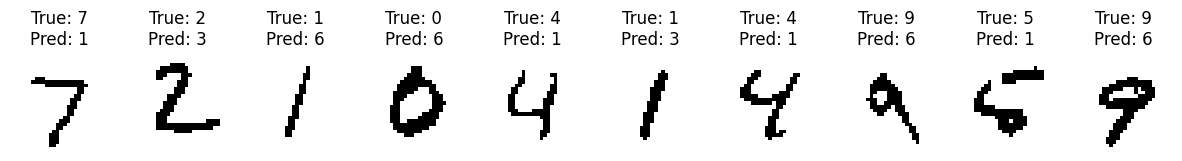

In [110]:
def show_classification_results(x, true_labels, pred_labels, n=10):
    fig, axes = plt.subplots(1, n, figsize=(15, 3))
    for i, ax in enumerate(axes):
        ax.imshow(x[i].reshape(28,28), cmap='binary')
        ax.set_title(f"True: {true_labels[i]}\nPred: {pred_labels[i]}")
        ax.axis('off')
    plt.show()

predictions_joint = rbm_joint.classify(X_test_binary)
accuracy_joint = np.mean(predictions_joint == Y_test)
print(f"Generative RBM Classification Accuracy: {accuracy_joint*100:.2f}%")

show_classification_results(X_test, Y_test, predictions_joint, n=10)

# DRBM model

Preparing the data:

In [57]:
# ---------------------------
# بارگذاری و پیش‌پردازش داده‌ها
# ---------------------------
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader  = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

The model:

In [66]:
class DiscriminativeRBMModel(nn.Module):
    def __init__(self, input_dim=784, num_classes=10, hidden_dim=256):
        super(DiscriminativeRBMModel, self).__init__()
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.hidden_dim = hidden_dim

        # پارامترهای مربوط به بخش تصویر
        self.b = nn.Parameter(torch.zeros(input_dim))
        # پارامترهای مربوط به برچسب
        self.d = nn.Parameter(torch.zeros(num_classes))
        # وزن‌های مربوط به اتصال تصویر به لایه پنهان
        self.W = nn.Parameter(torch.randn(input_dim, hidden_dim) * 0.1)
        # وزن‌های مربوط به اتصال برچسب به لایه پنهان
        self.U = nn.Parameter(torch.randn(num_classes, hidden_dim) * 0.1)
        # بایاس لایه پنهان
        self.c = nn.Parameter(torch.zeros(hidden_dim))

    def free_energy(self, x, y):
        vbias_term = torch.matmul(x, self.b) + torch.matmul(y, self.d)
        hidden_linear = torch.matmul(x, self.W) + torch.matmul(y, self.U) + self.c
        # Clamp کردن ورودی به exp برای جلوگیری از overflow
        hidden_linear = torch.clamp(hidden_linear, max=50)
        hidden_term = torch.sum(torch.log(1 + torch.exp(hidden_linear)), dim=1)
        return -vbias_term - hidden_term


    def forward(self, x):
        """
        برای هر نمونه ورودی x (به شکل (batch, 784))، با استفاده از تابع free energy،
        برای هر برچسب ممکن (به صورت One-hot) مقادیر -F(x,y) (که معادل logits هستند) محاسبه می‌شود.
        خروجی logits به شکل (batch, num_classes) خواهد بود.
        """
        batch_size = x.size(0)
        logits = []
        for label in range(self.num_classes):
            y_candidate = torch.zeros(batch_size, self.num_classes, device=x.device)
            y_candidate[:, label] = 1.0
            F = self.free_energy(x, y_candidate)   # (batch,)
            logits.append((-F).unsqueeze(1))
        logits = torch.cat(logits, dim=1)  # (batch, num_classes)
        return logits

Training the model:

In [67]:
# ---------------------------
# آموزش مدل تمایزگر
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DiscriminativeRBMModel(input_dim=784, num_classes=10, hidden_dim=256).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 10

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)
        # بایناریزه کردن تصاویر (اگر لازم باشد)
        images = (images > 0.5).float()
        images = images.view(images.size(0), -1)

        optimizer.zero_grad()
        logits = model(images)  # (batch, num_classes)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(trainset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.5f}")

Epoch 1/10, Loss: 0.23599
Epoch 2/10, Loss: 0.10353
Epoch 3/10, Loss: 0.07536
Epoch 4/10, Loss: 0.05815
Epoch 5/10, Loss: 0.05386
Epoch 6/10, Loss: 0.04407
Epoch 7/10, Loss: 0.04030
Epoch 8/10, Loss: 0.03591
Epoch 9/10, Loss: 0.03353
Epoch 10/10, Loss: 0.03283


Testing the model:

In [68]:
# ---------------------------
# ارزیابی مدل تمایزگر
# ---------------------------
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        images = (images > 0.5).float()
        images = images.view(images.size(0), -1)
        logits = model(images)
        _, predicted = torch.max(logits.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Discriminative Model Accuracy: {accuracy*100:.2f}%")

Discriminative Model Accuracy: 96.55%
